Let's first try if the functionality works

In [1]:

from Differential_drive_MPC import DifferentialDriveMPC, DifferentialDriveMPCOptions
import gc
import numpy as np
import matplotlib.pyplot as plt
from utils_diff_drive import simulate_closed_loop
from plotting_utils_diff_drive import plot_diff_drive_trajectory
from utils_diff_drive import compute_exponential_step_sizes

# Compile MPC

# mpc_opts = DifferentialDriveMPCOptions()
# N = 100
# mpc_opts.N = N
# dt_inital_mpc = 0.05 # inital step size of 0.003 already fails!!!
# # mpc_opts.step_sizes = compute_exponential_step_sizes(
# #     dt_initial=0.01,
# #     T_total=20.0,
# #     N_steps=N,
# #     plot=True
# # ) #[dt_inital_mpc]*10000
# mpc_opts.step_sizes = [dt_inital_mpc]*N
# mpc_opts.switch_stage = 5000
# mpc_opts.integrator_type = "IRK"
# # mpc_opts.ellipse_centers = np.array([
# #         [-0.5, 0.3],  # Center of first ellipse
# #     ])
# # mpc_opts.ellipse_half_axes = np.array([
# #         [0.01, 0.01],   # Half-axis lengths (a, b) for first ellipse
# #     ])
# mpc = DifferentialDriveMPC(mpc_opts)

# print("Acados compiles sucessfully")

# # call solve for given initial state
# X0 = np.array([-1.0, 1.0, 0.0, -np.pi/2, 0.0, 0.0, 0.0])  #np.array([1.0, 0.0, 0.0, np.pi, 0.0, 0.0, 0.0])  # Intital state
# mpc.solve(X0)
# print("Solve runs through succesfully")

# # Visualize open loop plan
# traj_x, traj_u = mpc.get_planned_trajectory()
# print(traj_u)
# plot_diff_drive_trajectory(np.zeros(2), mpc=mpc, open_loop_plan=traj_x)

# # Try simulation in closed loop
# duration = 4.0
# if True:

#     mpc_opts_sim = DifferentialDriveMPCOptions()
#     mpc_opts_sim.N = 1
#     dt_sim = 0.01
#     mpc_opts_sim.step_sizes = [dt_sim]*1
#     mpc_opts_sim.switch_stage = 2
#     mpc_sim = DifferentialDriveMPC(mpc_opts_sim)
#     control_step = int(dt_inital_mpc/dt_sim)
#     print("control_step:", control_step)
#     x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop(X0, mpc, duration, sim_solver=mpc_sim.acados_sim_solver, control_step=control_step)
#     print("Closed loop sim runs through succesfully")

#     plot_diff_drive_trajectory(np.zeros(2), mpc=mpc, closed_loop_traj=x_traj)

#     print("mean solve time:", np.mean(solve_times))
#     print("mean costs:", np.mean(stage_costs))

#     x_traj = np.array(x_traj)
#     u_traj = np.array(u_traj)

#     time_x = np.arange(x_traj.shape[0]) * control_step
#     time_u = np.arange(u_traj.shape[0]) * control_step

#     nx = x_traj.shape[1]
#     nu = u_traj.shape[1]

#     # Plot states
#     plt.figure(figsize=(12, 6))
#     for i in range(nx):
#         plt.plot(time_x, x_traj[:, i], label=f"$x_{i}$")
#     plt.xlabel("Time [s]")
#     plt.ylabel("States")
#     plt.title("State Trajectory Over Time")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     # Plot controls
#     plt.figure(figsize=(10, 4))
#     for i in range(nu):
#         plt.step(time_u, u_traj[:, i], where='post', label=f"$u_{i}$")
#     plt.xlabel("Time [s]")
#     plt.ylabel("Control Inputs")
#     plt.title("Control Inputs Over Time")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

# del mpc
# del mpc_sim
# gc.collect()


For our experiment, we compare the following MPCs. As ground truth model we consider the model integrated with step size 0.005. Consistently, we simulate at 200Hz and apply the MPCs with a frequency (zero order hold) corresponding to their initial step size.

0) Baseline: Naive Long Horizon MPC, step size is 0.01 and we have an enormous horizon length of 1000. Thus, the MPC's planning horizon captures half of the entire 20s simulation. The MPC reaches a state very close to the goal state and achieves small costs. 

1) Exact-model MPC with a larger initial step size of 0.02 and a horizon of 1000 (again overlooking half the simulaiton horizon). The MPC does not work at all, and the solver frequently fails. My understanding: The larger step size is too large and the dynamics of the MPC do not accurately capture the ground truth system anymore. 

2) Exactly as 0), but integrated with ERK. We get solver errors. My understanding: ERK cannot handle the stiff dynamics. 

3) Exact-model MPC with initial step size of 0.002 and a shorter time horizon of 250. The shorter horizon leads to worse performance in terms of costs and a deviation from the goal state. This effect increases when further decreasing the horizon length.

4) Exact-model MPC with exponential increase of step size at an sensible rate. We choose 100 stages. The time horizon is still 20s to achieve a far lookahead distance.

5) Our approach: Combining exponential increase of step size with model switching after stage 20. Neglecting the fast actuator dynamics, we not only reduce the dimension of the state but can switch to ERK for the second part of the horizon, which is much cheaper than using the implicit IRK.

In [2]:
import gc
import shutil

# initialize sim solver for closed loop simulation, we also use the DifferentialDrive MPC class to instatiate the sim solver.
mpc_opts_sim = DifferentialDriveMPCOptions()
mpc_opts_sim.N = 1
dt_sim = 0.005
mpc_opts_sim.step_sizes = [dt_sim]*1
mpc_opts_sim.switch_stage = 2
mpc_sim = DifferentialDriveMPC(mpc_opts_sim)
sim_solver = mpc_sim.acados_sim_solver

# MPC config shared by all MPCs 
dt_inital_mpc = 0.01
control_step = int(dt_inital_mpc/dt_sim) # determines zero order hold of the MPC
X0 = np.array([-1.0, 1.0, 0.0, -np.pi/2, 0.0, 0.0, 0.0])
duration = 20.0

# collect mean costs and solve times
mean_costs = []
mean_solve_times = []

del mpc_sim
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)



got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

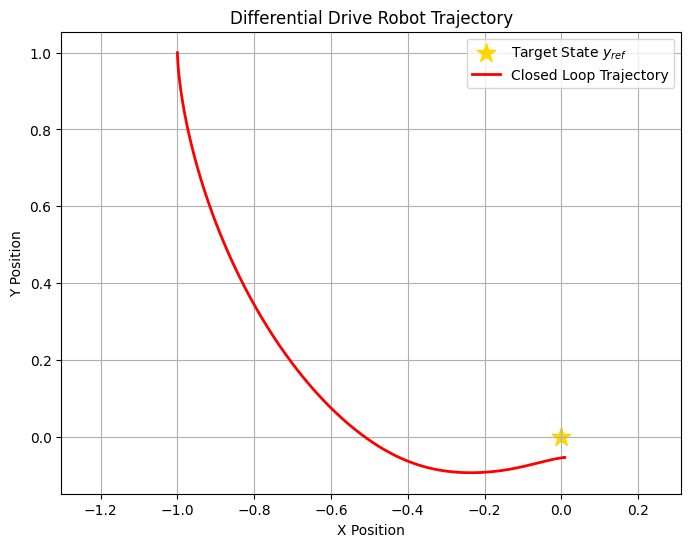

In [3]:
### 0) Baseline ###
mpc_opts_baseline = DifferentialDriveMPCOptions()
N = 1000
mpc_opts_baseline.N = N
mpc_opts_baseline.step_sizes = [dt_inital_mpc]*N
mpc_opts_baseline.switch_stage = N+1
mpc_opts_baseline.integrator_type = "IRK"
mpc_baseline = DifferentialDriveMPC(mpc_opts_baseline)

x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop(X0, mpc_baseline, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(np.zeros(2), mpc=mpc_baseline, closed_loop_traj=x_traj)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_baseline
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

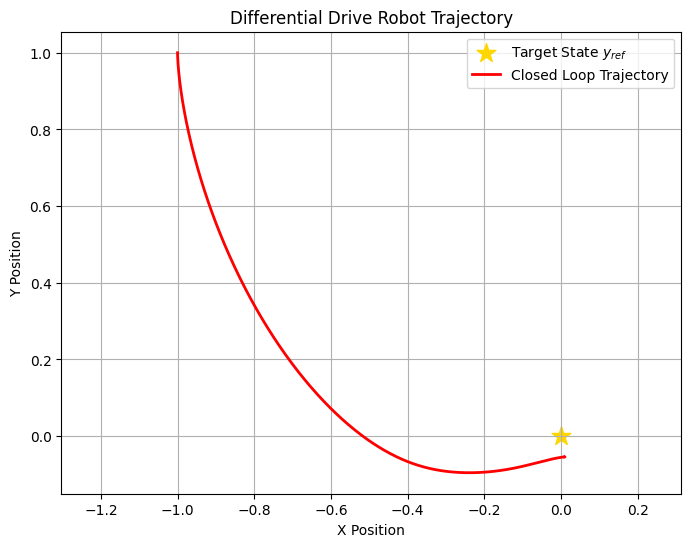

In [4]:
### 1) Larger step size ###
mpc_opts_1 = DifferentialDriveMPCOptions()
N = 250
mpc_opts_1.N = N
mpc_opts_1.step_sizes = [4*dt_inital_mpc]*N
mpc_opts_1.switch_stage = N+1
mpc_opts_1.integrator_type = "IRK"
mpc_1 = DifferentialDriveMPC(mpc_opts_1)

x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop(X0, mpc_1, duration, sim_solver=sim_solver, control_step=4*control_step)
plot_diff_drive_trajectory(np.zeros(2), mpc=mpc_1, closed_loop_traj=x_traj)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_1
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

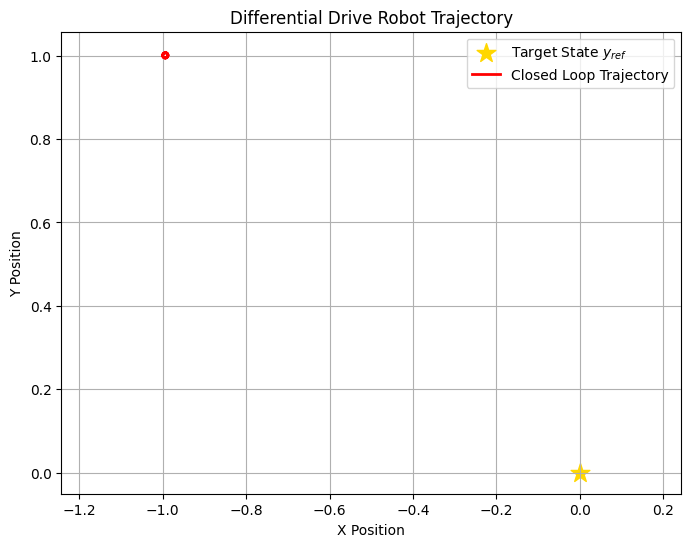

In [5]:
### 2) ERK usage ###
mpc_opts_2 = DifferentialDriveMPCOptions()
N = 1000
mpc_opts_2.N = N
mpc_opts_2.step_sizes = [dt_inital_mpc]*N
mpc_opts_2.switch_stage = N+1
mpc_opts_2.integrator_type = "ERK"
mpc_2 = DifferentialDriveMPC(mpc_opts_2)

x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop(X0, mpc_2, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(np.zeros(2), mpc=mpc_2, closed_loop_traj=x_traj)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_2
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)



got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

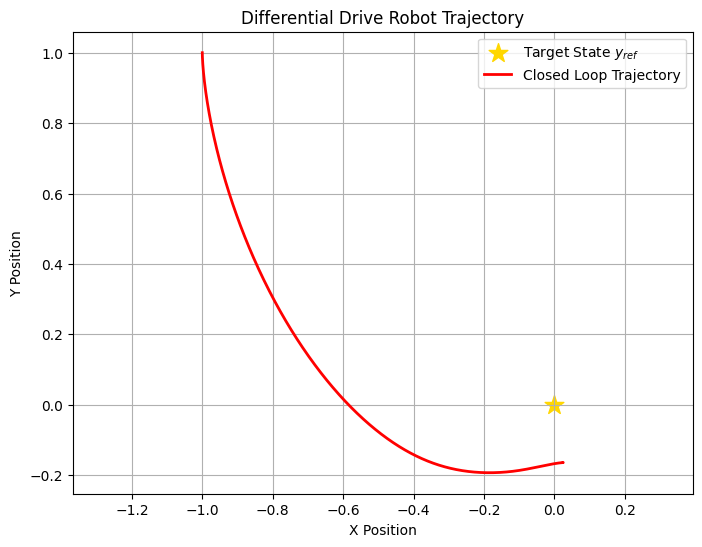

In [6]:
### 3) Myopic Exact model MPC ###
mpc_opts_3 = DifferentialDriveMPCOptions()
N = 250
mpc_opts_3.N = N
mpc_opts_3.step_sizes = [dt_inital_mpc]*N
mpc_opts_3.switch_stage = N+1
mpc_opts_3.integrator_type = "IRK"
mpc_3 = DifferentialDriveMPC(mpc_opts_3)

x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop(X0, mpc_3, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(np.zeros(2), mpc=mpc_3, closed_loop_traj=x_traj)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_3
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)


got cost_type EXTERNAL for cost_type_e, hessian_approx: 'GAUSS_NEWTON'.
With this setting, acados will proceed computing the exact Hessian for the cost term and no Hessian contribution from constraints and dynamics.
If the external cost is a linear least squares cost, this coincides with the Gauss-Newton Hessian.
Note: There is also the option to use the external cost module with a numerical Hessian approximation (see `ext_cost_num_hess`).
OR the option to provide a symbolic custom Hessian approximation (see `cost_expr_ext_cost_custom_hess`).

rm -f libacados_ocp_solver_actuators_diff_drive_with_actuators.so
rm -f acados_solver_actuators_diff_drive_with_actuators.o
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterth

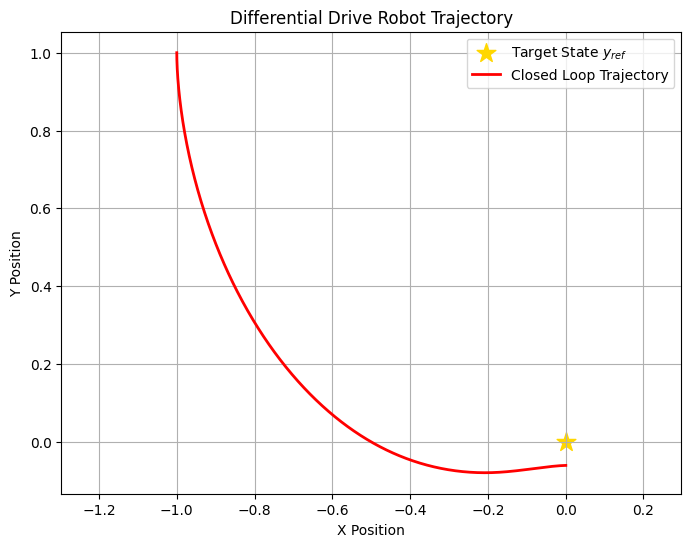

In [ ]:
### 4) Exponential increase in stepsize ###
mpc_opts_4 = DifferentialDriveMPCOptions()
N = 80
mpc_opts_4.N = N
mpc_opts_4.step_sizes = compute_exponential_step_sizes(
    dt_initial=dt_inital_mpc,
    T_total=10,
    N_steps=N,
    plot=False
)
mpc_opts_4.switch_stage = N+1
mpc_opts_4.integrator_type = "IRK"
mpc_4 = DifferentialDriveMPC(mpc_opts_4)

x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop(X0, mpc_4, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(np.zeros(2), mpc=mpc_4, closed_loop_traj=x_traj)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_4
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option full_step_dual is deprecated and has new name: globalization_full_step_dual
The option line_search_use_sufficient_descent is deprecated and has new name: globalization_line_search_use_sufficient_descent
The option nlp_solver_step_length is deprecated and has new name: globalization_fixed_step_length
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_min is deprecated and has new name: globalization_alpha_min
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option alpha_reduction is deprecated and has new name: globalization_alpha_reduction
The option eps_sufficient_descent is deprecated and has new name: globaliza

acados_solver_multiphase_ocp_20_1_30_20250321_002953_151122.c: In function ‘multiphase_ocp_20_1_30_20250321_002953_151122_acados_create_with_discretization’:
acados_solver_multiphase_ocp_20_1_30_20250321_002953_151122.c:1544:25: warning: too many arguments for format [-Wformat-extra-args]
 1544 |         fprintf(stderr, "multiphase_ocp_20_1_30_20250321_002953_151122_acados_create_with_discretization: new_time_steps should be NULL " \
      |                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o actuators_diff_drive_with_actuators_model/actuators_diff_drive_with_actuators_impl_dae_fun.o actuators_diff_drive_with_actuators_model/actuators_diff_drive_with_actuators_impl_dae_fun.c
cc -fPIC -std=c99   -O2 -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/acados -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/blasfeo/include -I/home/lukas/ETH_Zuerich/ASL_Stanford_Masterthesis/Workspace/acados/include/hpipm/include  -c -o actuators_diff_drive_with_actuators_model/actuators_diff_drive

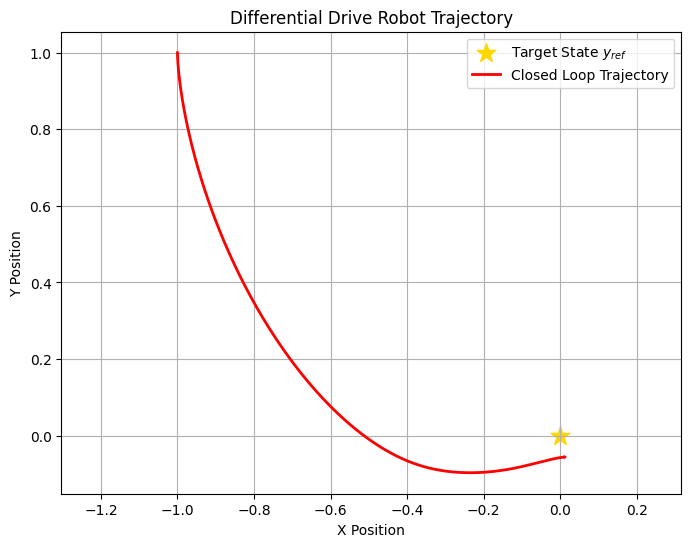

In [ ]:
### 5) Mixed model, ERK second phase, exponential step size increase ###
mpc_opts_5 = DifferentialDriveMPCOptions()
N = 80
mpc_opts_5.N = N
mpc_opts_5.step_sizes = compute_exponential_step_sizes(
    dt_initial=dt_inital_mpc,
    T_total=10,
    N_steps=N,
    plot=False
)
mpc_opts_5.switch_stage = 20 # only keep actuator model in first part of the horizon
mpc_opts_5.integrator_type = "IRK" # switch to ERK happens automatically in the class
mpc_5 = DifferentialDriveMPC(mpc_opts_5)

x_traj, u_traj, stage_costs, solve_times = simulate_closed_loop(X0, mpc_5, duration, sim_solver=sim_solver, control_step=control_step)
plot_diff_drive_trajectory(np.zeros(2), mpc=mpc_5, closed_loop_traj=x_traj)
mean_costs.append(np.mean(stage_costs))
mean_solve_times.append(np.mean(solve_times))

del mpc_5
gc.collect()
shutil.rmtree('c_generated_code', ignore_errors=True)

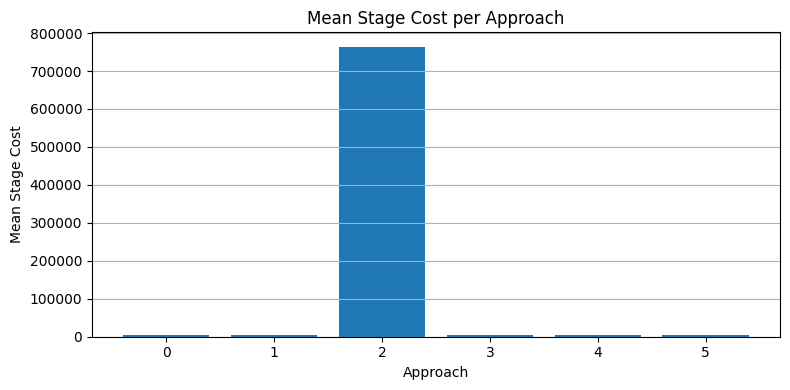

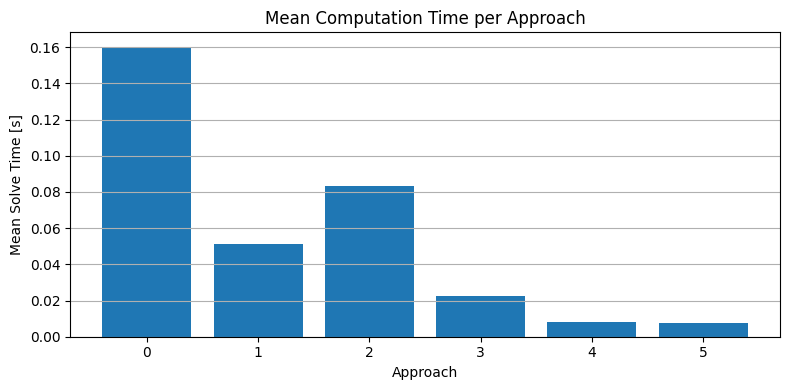

In [9]:
# Plot as bar diagrams the mean costs and mean computation times of the different approaches
# X-axis labels for the bars
labels = [0, 1, 2, 3, 4, 5]

# Plot 1: Mean Stage Costs
plt.figure(figsize=(8, 4))
plt.bar(labels, mean_costs)
plt.xlabel("Approach")
plt.ylabel("Mean Stage Cost")
plt.title("Mean Stage Cost per Approach")
plt.xticks(labels)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Plot 2: Mean Computation Time
plt.figure(figsize=(8, 4))
plt.bar(labels, mean_solve_times)
plt.xlabel("Approach")
plt.ylabel("Mean Solve Time [s]")
plt.title("Mean Computation Time per Approach")
plt.xticks(labels)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

In [10]:
print(mean_costs)
print(mean_solve_times)

[3544.377204051987, 3567.8396410136975, 763798.8458674462, 3854.565840777218, 3715.0081508969884, 3546.1826312691924]
[0.16016822, 0.051306738, 0.0830913655, 0.022323129, 0.008382825500000001, 0.007664948499999999]
